In [1]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
def load_npy(kind, hold_position):
    file_path = "../Output/" + kind + "/" + kind + "_" + hold_position + "/" + kind + "_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_glo_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
#     z_gyro_FFT_sum = np.load(file_path + "_glo_gyro_z_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_glo_mag_norm_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    predict1 = np.load(file_path + "_spectram_predict_0608.npy")
    if kind == "train":
        user = [1] * 195491
    else:
#         user = np.load("validation_user.npy") + 2
        user = [2] * 14813 + [3] * 13872
    user = np.array(user).reshape([-1, 1])
#     predict2 = np.load(file_path + "_spectram_predict_0527.npy")
#     predict3 = np.load(file_path + "_spectram_predict_0528.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")
#     xy_gyro_FFT = np.load(file_path + "_glo_gyro_xy_ver2_amplitude_frequency_range5Hz.npy")
#     z_gyro_FFT = np.load(file_path + "_glo_gyro_z_ver2_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_glo_mag_norm_ver2_amplitude_frequency_range5Hz.npy")
#     result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
#                              z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, predict1, user, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, norm_mag_FFT_sum, predict1, user, z_lacc_FFT, norm_mag_FFT], axis=1)
    
#     del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [3]:
Y_train = np.delete(np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0], 120845, 0).reshape([-1])

Y_train.shape

(195490,)

In [4]:
# train_Bag = np.delete(load_npy("train", "Bag"), 120845, 0)
train_Hips = np.delete(load_npy("train", "Hips"), 120845, 0)
# train_Torso = np.delete(load_npy("train", "Torso"), 120845, 0)
# train_Hand = np.delete(load_npy("train", "Hand"), 120845, 0)

train_Hips.shape

(195490, 74)

In [5]:
# X_train = np.concatenate([train_Bag[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hips, \
#                           train_Torso[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hand[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)
# X_train = np.concatenate([train_Bag, train_Hips, train_Torso], axis=0)
X_train = train_Hips
X_train.shape

(195490, 74)

In [6]:
# Y_train = np.concatenate([Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           Y_train, \
#                           Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)], \
#                           Y_train[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)
Y_train = Y_train.reshape([-1, 1])
# Y_train = np.concatenate([Y_train, Y_train, Y_train], axis=0)
Y_train.shape

(195490, 1)

In [7]:
def separate(x, y):
    result_x = []
    result_y = []
    for i in range(8):
        tmp = np.where(y == (i+1))[0]
        tmp = tmp[0:tmp.shape[0]:100]
        tmp_x = x[tmp]
        tmp_y = y[tmp]
        result_x.append(tmp_x)
        result_y.append(tmp_y)
    
    x = result_x[0]
    y = result_y[0]
    for tmp in result_x[1:]:
        x = np.concatenate([x, tmp], axis=0)
    for tmp in result_y[1:]:
        y = np.concatenate([y, tmp], axis=0)
    return x, y

X_train, Y_train = separate(X_train, Y_train)
X_train.shape, Y_train.shape

((1960, 74), (1960, 1))

In [8]:
# validation_Bag = load_npy("validation", "Bag")
validation_Hips = load_npy("validation", "Hips")
# validation_Torso = load_npy("validation", "Torso")
# validation_Hand = load_npy("validation", "Hand")

validation_Hips.shape

(28685, 74)

In [9]:
# X_val = np.concatenate([validation_Bag, validation_Hips, validation_Torso, validation_Hand], axis=0)
# X_val = np.concatenate([validation_Bag, validation_Hips, validation_Torso], axis=0)
val = validation_Hips
val.shape

(28685, 74)

In [10]:
val_label = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
val_label.shape

(28685, 1)

In [11]:
def load_npy():
    file_path = "../Output/test/test"
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_glo_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
#     z_gyro_FFT_sum = np.load(file_path + "_glo_gyro_z_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_glo_mag_norm_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    predict1 = np.load(file_path + "_spectram_predict_0608.npy").reshape([-1, 1])
    user = np.load(file_path + "_user.npy")
#     predict2 = np.load(file_path + "_spectram_predict_0527.npy").reshape([-1, 1])
#     predict3 = np.load(file_path + "_spectram_predict_0528.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")
#     xy_gyro_FFT = np.load(file_path + "_glo_gyro_xy_ver2_amplitude_frequency_range5Hz.npy")
#     z_gyro_FFT = np.load(file_path + "_glo_gyro_z_ver2_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_glo_mag_norm_ver2_amplitude_frequency_range5Hz.npy")
#     result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
#                              z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, predict1, user, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, norm_mag_FFT_sum, predict1, user, z_lacc_FFT, norm_mag_FFT], axis=1)
#     del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, predict1, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [12]:
test = load_npy()
test.shape

(57573, 74)

## 標準化(sklearn)

In [ ]:
train_std = StandardScaler()

X_train[:, :39] = train_std.fit_transform(X_train[:, :39])
X_train[:, 40:X_train.shape[1]:2] = train_std.fit_transform(X_train[:, 40:X_train.shape[1]:2])

X_train.shape

In [ ]:
user23_std = StandardScaler()

user23 = np.concatenate([val, test], axis=0)

user23_std.fit(user23[:, :39])
val[:, :39] = user23_std.transform(val[:, :39])
test[:, :39] = user23_std.transform(test[:, :39])

user23_std.fit(user23[:, 41:user23.shape[1]:2])
val[:, 40:val.shape[1]:2] = user23_std.fit_transform(val[:, 40:val.shape[1]:2])
test[:, 40:test.shape[1]:2] = user23_std.fit_transform(test[:, 40:test.shape[1]:2])

val.shape, test.shape

## ユーザごとに標準化
### 標準化をvalidationデータとtestデータをまとめて行なうということ

In [13]:
user_index = 29

# trainデータの標準化は同じ
train_std = StandardScaler()
X_train[:, :user_index-1] = train_std.fit_transform(X_train[:, :user_index-1])
X_train[:, [i for i in range(user_index+1, X_train.shape[1], 2)]] = train_std.fit_transform(X_train[:, [i for i in range(user_index+1, X_train.shape[1], 2)]])

# user2とuser3でまとめて標準化して、パラメータをとっておけば良い
user2_1_std = StandardScaler()
user2_2_std = StandardScaler()
user2 = np.concatenate([val[val[:, user_index] == 2].copy(), test[test[:, user_index] == 2].copy()], axis=0)
user2_1_std.fit(user2[:, :user_index-1])
# user2_2_std.fit(user2[:, user_index+1:])
user2_2_std.fit(user2[:, [i for i in range(user_index+1, user2.shape[1], 2)]])
user3_1_std = StandardScaler()
user3_2_std = StandardScaler()
user3 = np.concatenate([val[val[:, user_index] == 3].copy(), test[test[:, user_index] == 3].copy()], axis=0)
user3_1_std.fit(user3[:, :user_index-1])
# user3_2_std.fit(user3[:, user_index+1:])
user3_2_std.fit(user3[:, [i for i in range(user_index+1, user3.shape[1], 2)]])

# 標準化
val[val[:, user_index] == 2, :user_index-1] = user2_1_std.transform(val[val[:, user_index] == 2, :user_index-1])
# val[val[:, user_index] == 2, user_index+1:] = user2_2_std.transform(val[val[:, user_index] == 2, user_index+1:])
val[val[:, user_index] == 2, user_index+1:val.shape[1]:2] = user2_2_std.transform(val[val[:, user_index] == 2, user_index+1:val.shape[1]:2])

test[test[:, user_index] == 2, :user_index-1] = user2_1_std.transform(test[test[:, user_index] == 2, :user_index-1])
# test[test[:, user_index] == 2, user_index+1:] = user2_2_std.transform(test[test[:, user_index] == 2, user_index+1:])
test[test[:, user_index] == 2, user_index+1:test.shape[1]:2] = user2_2_std.transform(test[test[:, user_index] == 2, user_index+1:test.shape[1]:2])

val[val[:, user_index] == 3, :user_index-1] = user3_1_std.transform(val[val[:, user_index] == 3, :user_index-1])
# val[val[:, user_index] == 3, user_index+1:] = user3_2_std.transform(val[val[:, user_index] == 3, user_index+1:])
val[val[:, user_index] == 3, user_index+1:val.shape[1]:2] = user3_2_std.transform(val[val[:, user_index] == 3, user_index+1:val.shape[1]:2])

test[test[:, user_index] == 3, :user_index-1] = user3_1_std.transform(test[test[:, user_index] == 3, :user_index-1])
# test[test[:, user_index] == 3, user_index+1:] = user3_2_std.transform(test[test[:, user_index] == 3, user_index+1:])
test[test[:, user_index] == 3, user_index+1:test.shape[1]:2] = user3_2_std.transform(test[test[:, user_index] == 3, user_index+1:test.shape[1]:2])

X_train.shape, val.shape, test.shape

((1960, 74), (28685, 74), (57573, 74))

In [14]:
X_train[:, user_index]

array([1., 1., 1., ..., 1., 1., 1.])

## パターン2で学習して良いvalidationデータだけ取り出す

In [ ]:
validation_Bag = X_val[X_val.shape[0]//4*0:X_val.shape[0]//4]
validation_Hips = X_val[X_val.shape[0]//4*1:X_val.shape[0]//4*2]
validation_Torso = X_val[X_val.shape[0]//4*2:X_val.shape[0]//4*3]
validation_Hand = X_val[X_val.shape[0]//4*3:]

validation_Bag.shape

In [ ]:
pattern_file = np.load("validation_pattern2.npy").reshape([-1])

# X_val = np.concatenate([validation_Bag[pattern_file == 1], validation_Hips[pattern_file == 1], validation_Torso[pattern_file == 1], validation_Hand[pattern_file == 1]], axis=0)
X_val = validation_Hips[pattern_file == 1]
Y_val = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
Y_val = Y_val.reshape([-1, 1])[pattern_file == 1]
# Y_val = np.concatenate([Y_val, Y_val, Y_val, Y_val], axis=0)
# print(Y_val.shape[0] // 4)
# Y_val_hold_position = np.zeros((14338*4, 1))
# for i in range(4):
#     Y_val_hold_position[14338*i:14338*(i+1)] = i
# Y_val = np.concatenate([Y_val, Y_val_hold_position], axis=1)

X_val.shape, Y_val.shape

In [15]:
pattern_file = np.load("validation_pattern2.npy").reshape([-1])
X_train = np.concatenate([X_train, val[pattern_file == 1]], axis=0)
X_val = val[pattern_file == 0]

Y_train = np.concatenate([Y_train, val_label[pattern_file == 1]], axis=0)
Y_val = val_label[pattern_file == 0]

X_test = val[pattern_file == 2]
Y_test = val_label[pattern_file == 2]

Y_train.shape, Y_val.shape, Y_test.shape

((16298, 1), (5696, 1), (8651, 1))

In [ ]:
train_Still = X_train[(Y_train==1)[:, 0]]
train_Walking = X_train[(Y_train==2)[:, 0]]
train_Run = X_train[(Y_train==3)[:, 0]]
train_Bike = X_train[(Y_train==4)[:, 0]]

train_Still.shape, train_Walking.shape, train_Run.shape, train_Bike.shape

In [ ]:
# train_Still = train_Still[np.random.choice(train_Still.shape[0], 33700, replace=False)]
train_Walking = train_Walking[np.random.choice(train_Walking.shape[0], 33700, replace=False)]
train_Bike = train_Bike[np.random.choice(train_Bike.shape[0], 33700, replace=False)]

train_Still.shape, train_Walking.shape, train_Bike.shape

In [ ]:
X_train = np.concatenate([train_Still, train_Walking, train_Run, train_Bike], axis=0)
Y_train = [1] * 557016 + [2] * 33700 + [3] * 33700 + [4] * 33700
Y_train = np.array(Y_train).reshape([-1, 1])
X_train.shape, Y_train.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle=False)

x_train.shape, x_test.shape

In [ ]:
%%time
evals_result = {}
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, gamma=0.005, sub_sample=0.9, colsample_bytree=0.8, n_estimators=10000,
                        n_jobs=-1, tree_method='gpu_hist', gpu_id=0)

model.fit(x_train, y_train, early_stopping_rounds=30, eval_set=[(x_train, y_train), (x_test, y_test)], eval_metric='merror', verbose=False, callbacks=[xgb.callback.record_evaluation(evals_result)])

In [16]:
%%time
evals_result = {}
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.01, gamma=0.005, sub_sample=0.9, colsample_bytree=0.8, \
                          n_estimators=10000,
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
learn_user = 2
model.fit(X_train[(X_train[:, user_index] == 1) | (X_train[:, user_index] == learn_user)], Y_train[(X_train[:, user_index] == 1) | (X_train[:, user_index] == learn_user)], early_stopping_rounds=10, \
          eval_set=[(X_train[(X_train[:, user_index] == 1) | (X_train[:, user_index] == learn_user)], Y_train[(X_train[:, user_index] == 1) | (X_train[:, user_index] == learn_user)]), \
                    (X_val[X_val[:, user_index] == learn_user], Y_val[X_val[:, user_index] == learn_user])], \
          eval_metric='merror', verbose=False, callbacks=[xgb.callback.record_evaluation(evals_result)])

C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 2.21 s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.005, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, sub_sample=0.9, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

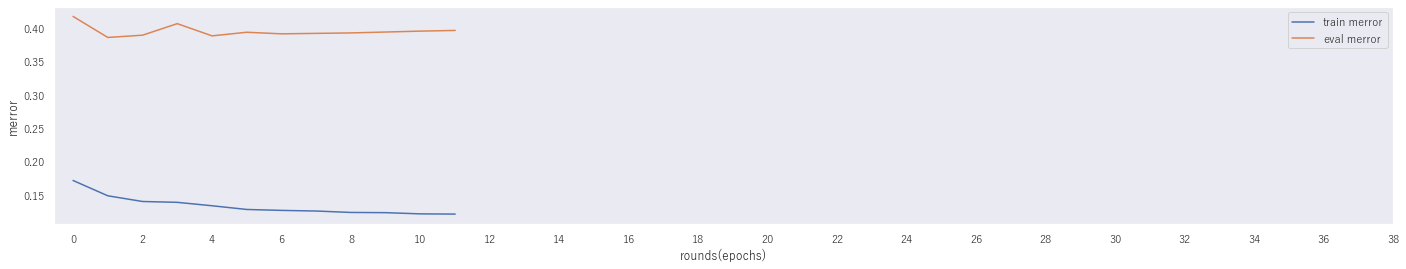

In [17]:
# 学習過程の名前は 'validation_{n}' になる
plt.figure(figsize=(24, 4))
train_metric = evals_result['validation_0']['merror']
plt.plot(train_metric, label='train merror')
eval_metric = evals_result['validation_1']['merror']
plt.plot(eval_metric, label='eval merror')
plt.grid()
plt.legend()
plt.xlabel('rounds(epochs)')
plt.ylabel('merror')
plt.xticks(np.arange(0, 38+1, 2))
plt.show()

In [18]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False, figsize=(16, 8)):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=24)
    fig.tight_layout()
    return ax

Text(0.5, 1, '0.509')

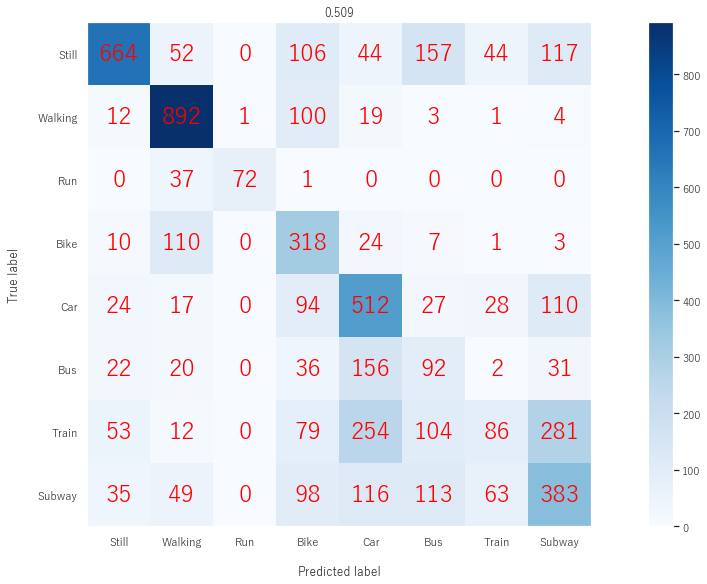

In [19]:
# class_names = ['Other', 'Walking', 'Run', 'Bike']
class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
predict = model.predict(X_val)
f1_macro = f1_score(Y_val, predict, average='macro')
plot_confusion_matrix(Y_val, predict, class_names, False)
plt.grid(False)
plt.title(round(f1_macro, 3))

In [ ]:
# class_names = ['Other', 'Walking', 'Run', 'Bike']
class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
predict = model.predict(X_val)

for i in range(2, 4):
    f1_macro = f1_score(Y_val[X_val[:,40] == i], predict[X_val[:,40] == i], average='macro')
    plot_confusion_matrix(Y_val[X_val[:,40] == i], predict[X_val[:,40] == i], class_names, False)
    plt.grid(False)
    plt.title("ユーザ" + str(i))
    print("ユーザ" + str(i), round(f1_macro, 3))

0.515

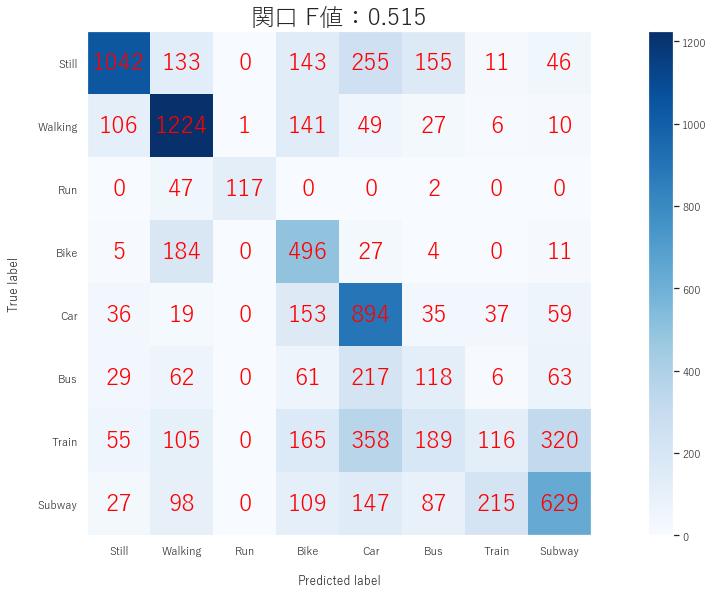

In [20]:
# class_names = ['Other', 'Walking', 'Run', 'Bike']
class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
predict = model.predict(X_test)
f1_macro = f1_score(Y_test, predict, average='macro')
plot_confusion_matrix(Y_test, predict, class_names, False)
plt.grid(False)
plt.title("関口 F値：" + str(round(f1_macro, 3)), fontsize=24)
round(f1_macro, 3)

ユーザ2 0.588
ユーザ3 0.402


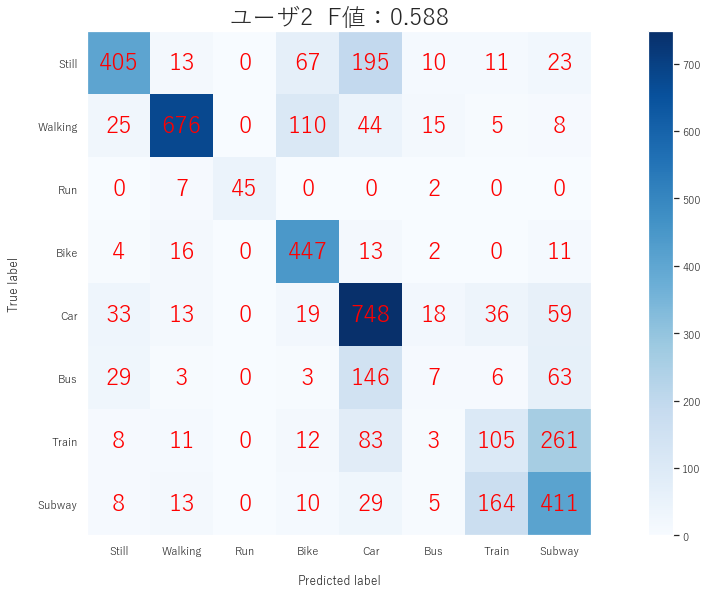

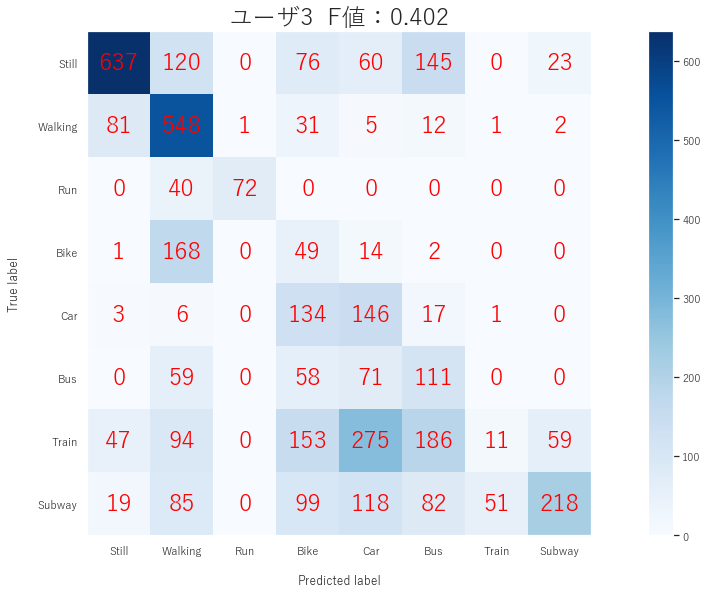

In [21]:
# class_names = ['Other', 'Walking', 'Run', 'Bike']
class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
predict = model.predict(X_test)

for i in range(2, 4):
    f1_macro = f1_score(Y_test[X_test[:,user_index] == i], predict[X_test[:,user_index] == i], average='macro')
    plot_confusion_matrix(Y_test[X_test[:,user_index] == i], predict[X_test[:,user_index] == i], class_names, False)
    plt.grid(False)
    plt.title("ユーザ" + str(i) + "  F値：" + str(round(f1_macro, 3)), fontsize=24)
    print("ユーザ" + str(i), round(f1_macro, 3))

In [ ]:
_, ax = plt.subplots(figsize=(12, 24))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.grid(False)

In [ ]:
import pickle

pickle.dump(model, open("model_0608_unknown_user.binaryfile", 'wb'))

In [ ]:
def predict(x, file_name):
    x_predict = model.predict_proba(x).reshape([-1, 8])
    np.save(file_name, x_predict)
    return x_predict

In [ ]:
train_Bag_predict = predict(X_train[X_train.shape[0]//4*0:X_train.shape[0]//4], "train_Bag_関口分類")
train_Hips_predict = predict(X_train[X_train.shape[0]//4:X_train.shape[0]//4*2], "train_Hips_関口分類")
train_Torso_predict = predict(X_train[X_train.shape[0]//4*2:X_train.shape[0]//4*3], "train_Torso_関口分類")
train_Hand_predict = predict(X_train[X_train.shape[0]//4*3:], "train_Hand_関口分類")

validation_Bag_predict = predict(X_val[X_val.shape[0]//4*0:X_val.shape[0]//4], "validation_Bag_関口分類")
validation_Hips_predict = predict(X_val[X_val.shape[0]//4:X_val.shape[0]//4*2], "validation_Hips_関口分類")
validation_Torso_predict = predict(X_val[X_val.shape[0]//4*2:X_val.shape[0]//4*3], "validation_Torso_関口分類")
validation_Hand_predict = predict(X_val[X_val.shape[0]//4*3:], "validation_Hand_関口分類")

In [ ]:
train_Hips_predict = predict(X_train, "train_Hips_関口分類")
validation_Hips_predict = predict(X_val, "validation_Hips_関口分類")

## パターン2のときこっち

In [ ]:
# train_Bag_predict = predict(X_train[X_train.shape[0]//4*0:X_train.shape[0]//4], "train_Bag_関口分類")
# train_Hips_predict = predict(X_train[X_train.shape[0]//4:X_train.shape[0]//4*2], "train_Hips_関口分類")
# train_Torso_predict = predict(X_train[X_train.shape[0]//4*2:X_train.shape[0]//4*3], "train_Torso_関口分類")
# train_Hand_predict = predict(X_train[X_train.shape[0]//4*3:], "train_Hand_関口分類")

# train_Hips_predict = predict(X_train[X_train[:, 40] == 1], "train_Hips_関口分類_pattern2")
train_Hips_predict = predict(X_train, "train_Hips_関口分類_pattern2")

# validation_Bag_predict = predict(validation_Bag, "validation_Bag_関口分類")
validation_Hips_predict = predict(val, "validation_Hips_関口分類_pattern2")
# validation_Torso_predict = predict(validation_Torso, "validation_Torso_関口分類")
# validation_Hand_predict = predict(validation_Hand, "validation_Hand_関口分類")

In [ ]:
best_f1_score = 0
best_param = {}

max_depth = [11, 12, 13]
min_child_weight = [3, 4, 5]
count = 1
for i in max_depth:
    for j in min_child_weight:
        evals_result = {}
        model = xgb.XGBClassifier(max_depth=i, min_child_weight=j, learning_rate=0.1,
                                  n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
        model.fit(X_train, Y_train)
#         model.fit(x_train, y_train, early_stopping_rounds=100, eval_set=[[(x_train, y_train), (x_test, y_test)]], eval_metric='merror', verbose_eval=False, callbacks=[xgb.callback.record_evaluation(evals_result)])
        print("{}回終わった".format(count))
        count += 1
        predict = model.predict(X_val)
        f1_macro = f1_score(Y_val, predict, average='macro')
        print({'max_depth': i, 'min_child_weight': j}, f1_macro)
        if f1_macro > best_f1_score:
            best_f1_score = f1_macro
            best_param = {'max_depth': i, 'min_child_weight': j}

print(round(best_f1_score, 3))
print(best_param)

# param = {
#     "max_depth":[i for i in range(3, 16, 3)], "min_child_weight":[i for i in range(6, 13, 2)]
#     # "gamma":[0.01, 0.05, 0.075, 0.1]
#     # "subsample":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00], "colsample_bytree":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
#     # "n_estimators":[250, 500, 750], "learning_rate":[0.05, 0.1]
#     # "reg_alpha":[0.1, 0.25, 0.5, 0.75]
# }

In [ ]:
# 学習過程の名前は 'validation_{n}' になる
train_metric = evals_result['validation_0']['merror']
plt.plot(train_metric, label='train merror')
eval_metric = evals_result['validation_1']['merror']
plt.plot(eval_metric, label='eval merror')
plt.grid()
plt.legend()
plt.xlabel('rounds(epochs)')
plt.ylabel('merror')
plt.show()

# testData推定

In [ ]:
test_predict = model.predict_proba(test)

test_predict.shape

In [ ]:
a = np.where((test_predict[:, 1] >= 0.75) | (test_predict[:, 2] >= 0.75) | (test_predict[:, 4] >= 0.75))[0]
# np.save("test_walking_run_car_index", a)
a.shape

In [ ]:
np.where(test_predict[:, 1] >= 0.75)[0].shape, np.where(test_predict[:, 2] >= 0.75)[0].shape, np.where(test_predict[:, 4] >= 0.75)[0].shape

In [ ]:
a = np.where((test_predict[:, 2] >= 0.75))[0]
np.save("test_run_index", a)

In [ ]:
np.save("test_関口分類_pattern2", test_predict)

In [ ]:
np.unique(np.where(test_predict >= 0.75)[0]).shape

In [ ]:
val_predict = model.predict_proba(val)
val_predict.shape

In [ ]:
np.unique(np.where(val_predict >= 0.50)[0]).shape